# [IAPR][iapr]: Lab 3 ‒  Classification
 

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [1]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [2]:
import platform
#print(platform.system())
#if platform.system() == "Darwin":
#    %pip install torch==1.8.1 torchvision==0.9.1
#else:
#    %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [4]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [5]:
### Task 1
### YOUR CODE

import numpy as np
from sklearn.covariance import LedoitWolf

# Define Mahalanobis distance function
def mahalanobis_dist(x, mean, cov):
    return np.sqrt((x - mean) @ np.linalg.inv(cov) @ (x- mean))

# Convert PyTorch tensors to NumPy arrays
train_features = train_features.numpy()
test_features = test_features.numpy()

# Compute class means
class_means = []
for label in [0, 1]:
    class_mean = np.mean(train_features[train_labels == label], axis=0)
    class_means.append(class_mean)
class_means = np.array(class_means)

# Compute class covariance matrices
class_covs = []
for label in [0, 1]:
    class_cov = LedoitWolf().fit(train_features[train_labels == label]).covariance_
    class_covs.append(class_cov)
class_covs = np.array(class_covs)

# Classify test features using minimum Mahalanobis distance
predictions = []
for test_feature in test_features:
    distances = []
    for label in [0, 1]:
        distance = mahalanobis_dist(test_feature, class_means[label], class_covs[label])
        distances.append(distance)
    predictions.append(np.argmin(distances))

predictions = np.array(predictions)

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [6]:
### Task 2
### YOUR CODE

# Compute accuracy
accuracy = (predictions == test_labels).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.978494623655914


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [7]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:**  
The Mahalanobis distance measures the distance between a point and a distribution while considering the covariance of the distribution. It can be used to determine how far a test example is from the training distribution. The minimum Mahalanobis distance can be a good OoD-ness score because it measures the similarity of the test example to each class and selects the minimum distance, which is the distance to the most similar class. A high minimum Mahalanobis distance indicates that the test example is far from all the classes in the training set and is likely an OoD example.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [8]:
### Task 2
### YOUR CODE

# Compute minimum Mahalanobis distance for every test example
min_distances = []
predictions_w_ood = []
for test_feature in test_features_w_ood:
    distances = []
    for label in [0, 1]:
        distance = mahalanobis_dist(test_feature, class_means[label], class_covs[label])
        distances.append(distance)
    min_distances.append(np.min(distances))
    predictions_w_ood.append(np.argmin(distances))

min_distances = np.array(min_distances)
predictions_w_ood = np.array(predictions_w_ood)

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

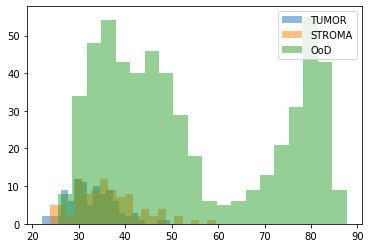

In [9]:
### Task 3
### YOUR CODE

import matplotlib.pyplot as plt

# Get Mahalanobis distances for TUMOR and STROMA
tumor_distances = min_distances[test_labels_w_ood == 0]
stroma_distances = min_distances[test_labels_w_ood == 1]
OoD_distances = min_distances[test_labels_w_ood == -1]

# Plot histogram
plt.hist(tumor_distances, bins = 20, alpha=0.5, label="TUMOR")
plt.hist(stroma_distances,  bins = 20, alpha=0.5, label="STROMA")
#plt.hist(min_distances,  bins = 20, alpha=0.5, label="TUMOR+STROMA+OoD")
plt.hist(OoD_distances, bins = 20, alpha=0.5, label="OoD")
plt.legend()
plt.show()

**Observations:** In the histogram, we can see that the OoD distances are generally larger than the ID distances, with a clear separation between the two distributions. This suggests that using a threshold on the minimum Mahalanobis distance could effectively filter out OoD examples. We can also see that the TUMOR and STROMA distances are similar, with some overlap between the two distributions.

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

In [10]:
### Task 4
### YOUR CODE

# Compute threshold to filter out 95% of OoD examples
threshold = np.percentile(OoD_distances, q=5)
print(f"Threshold: {threshold}")

# Filter out OoD examples and Compute number of TUMOR and STROMA examples that have been filtered out
tumor_filtered_out = np.sum((test_labels_w_ood==0) & (min_distances > threshold))/np.sum(test_labels_w_ood==0)
print(f"TUMOR Filtered out (in percent): {(tumor_filtered_out*100)}")
stroma_filtered_out = np.sum((test_labels_w_ood==1) & (min_distances > threshold))/np.sum(test_labels_w_ood==1)
print(f"STROMA Filtered out (in percent): {(stroma_filtered_out*100)}")

Threshold: 30.76951265335083
TUMOR Filtered out (in percent): 61.29032258064516
STROMA Filtered out (in percent): 74.19354838709677


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [11]:
### Task 5
### YOUR CODE

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assign prediction -1 to filtered out examples
predictions_w_ood[min_distances >= threshold] = -1

# Compute confusion matrix
conf_mat = confusion_matrix(test_labels_w_ood, predictions_w_ood)

# Extract class-wise accuracies from the confusion matrix
accuracy_tumor = (conf_mat.diagonal()*100/conf_mat.sum(axis=1))[1]
accuracy_stroma = (conf_mat.diagonal()*100/conf_mat.sum(axis=1))[2]
accuracy_OoD = (conf_mat.diagonal()*100/conf_mat.sum(axis=1))[0]

# Print class-wise accuracies
print(f"TUMOR accuracy: {accuracy_tumor}")
print(f"STROMA accuracy: {accuracy_stroma}")
print(f"OoD accuracy: {accuracy_OoD}")

TUMOR accuracy: 38.70967741935484
STROMA accuracy: 25.806451612903224
OoD accuracy: 94.9820788530466


Overall, the Mahalanobis distance-based approach seems to work well for OoD. However, we see that the accuracy for the TUMOR and STROMA tissues is very low. As the primary objective is to identify TUMOR and STROMA tissues rather than OoD-samples, the method used is **unsatisfactory** due to its poor accuracy in predicting these samples. One possible reason for this poor accuracy is that many samples of these tissues were filtered out.

### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [12]:
### Task 1
### YOUR CODE

import torch
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

# Convert NumPy arrays back to PyTorch tensors
train_features = torch.from_numpy(train_features)
train_labels = torch.from_numpy(train_labels)
test_features = torch.from_numpy(test_features)
test_labels = torch.from_numpy(test_labels)

# Train k-NN classifier
k = 8
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_features, train_labels)

# Classify test features
predictions = knn.predict(test_features)

# Convert predictions to PyTorch tensor
predictions = torch.from_numpy(predictions)

# Compute accuracy
accuracy = (predictions == test_labels).float().mean()
print(f"Accuracy: {accuracy}")


Accuracy: 1.0


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

In [13]:
### Task 2
### YOUR CODE

#it is faster to compute when we choose a small number of neighbors. Moreover in far neighbors, there are more chances that some samples are OoD.
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_features, train_labels)
score_out = knn.kneighbors(test_features_w_ood, return_distance=True)[0][:, -1]

# Compute thereshold such that 95% of the OoD examples are filtered out
knn_tissues = {}
for tissue in label_to_classname_w_ood.keys():
    knn_tissues[label_to_classname_w_ood[tissue]] = np.array(score_out)[test_labels_w_ood == tissue]

ood_thresh = np.percentile(knn_tissues["OoD"], 5)
print(f"Threshold: {ood_thresh}")

# How much TUMOR and STROMA have also been filtered out?
tumor_filtered_out = sum((test_labels_w_ood == 0) & (score_out >= ood_thresh))
stroma_filtered_out = sum((test_labels_w_ood == 1) & (score_out >= ood_thresh))
ood_filtered_out = sum((test_labels_w_ood == -1) & (score_out >= ood_thresh))

print(f"TUMOR filtered out: {tumor_filtered_out}")
print(f"STROMA filtered out: {stroma_filtered_out}")
print(f"OoD filtered out: {ood_filtered_out}")


# How much TUMOR and STROMA have also been filtered out? (in percentage)
tumor_filtered_out_percentage = tumor_filtered_out / sum(test_labels_w_ood == 0)
stroma_filtered_out_percentage = stroma_filtered_out / sum(test_labels_w_ood == 1)
ood_filtered_out_percentage = ood_filtered_out / sum(test_labels_w_ood == -1)

print(f'TUMOR filtered out (in percent): {tumor_filtered_out_percentage*100:}')
print(f'STROMA filtered out (in percent): {stroma_filtered_out_percentage*100:}')
print(f'OoD filtered out (in percent): {ood_filtered_out_percentage*100:}')


# Assign prediction -1 to filter out examples
prediction_labels = np.where(score_out >= ood_thresh, -1, knn.predict(test_features_w_ood))

# Compute the average class-wise accuracy of the prediction with test labels
tumor_accuracy = np.mean((prediction_labels[test_labels_w_ood == 0] == 0))
stroma_accuracy = np.mean((prediction_labels[test_labels_w_ood == 1] == 1))
ood_accuracy = np.mean((prediction_labels[test_labels_w_ood == -1] == -1))

class_wise_accuracy = []
for i in range(3):
    idx = (test_labels_w_ood == i) & (prediction_labels != -1)
    if sum(idx) == 0:
        class_wise_accuracy.append(0)
    else:
        class_wise_accuracy.append(sum(test_labels_w_ood[idx] == prediction_labels[idx]) / sum(idx))
        
average_accuracy = 1/3 * (sum(class_wise_accuracy))

print(f"TUMOR Accuracy {tumor_accuracy}")
print(f"STROMA Accuracy {stroma_accuracy}")
print(f"OoD Accuracy {ood_accuracy}")
print(f"Average Accuracy {average_accuracy}")

Threshold: 40.76716651916504
TUMOR filtered out: 65
STROMA filtered out: 44
OoD filtered out: 530
TUMOR filtered out (in percent): 69.89247311827957
STROMA filtered out (in percent): 47.31182795698925
OoD filtered out (in percent): 94.98207885304659
TUMOR Accuracy 0.3010752688172043
STROMA Accuracy 0.5268817204301075
OoD Accuracy 0.9498207885304659
Average Accuracy 0.6666666666666666


**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer:** Based on the experiments, it seems that k-NN distance is better than the Mahalanobis distance. In our scenario, we observed an increase in accuracy when using k-NN instead of Mahalanobis distance, specifically for STROMA examples. The possible reason is that k-NN filters out **fewer** points and also more robust to outliers. Although the increase in accuracy is not **significant**, it is still observed to be slightly higher than that of Mahalanobis distance. However, the choice between the two methods ultimately depends on the specific characteristics of the data and the application at hand.



**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:** The approach of using a threshold to filter out OoD points may not be sufficient for computing the TUMOR/STROMA ratio automatically because: 

1. Many samples are filtered out not suitably and hence we do not have very powerful measures.
2. It is reliable on labeled dataset which is not always available in many situations.


To improve the method,

1. We can use some modern techniques in machine learning or deep learning such as generating pseudo labels, doing self-supervisied learning, transfer learning and domain adaptation.

2. Using more robust (to outliers) distance functions such as Huber distance.

---

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories: 

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [14]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [15]:
# Load the features
features_path = '../data/lab-03-data/part2/sipakmed_clean_embeddings.pth'

In [16]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.labels)
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [17]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path, phase='train')
val_dataset = Sipakmed(features_path, phase='val')
test_dataset = Sipakmed(features_path, phase='test')

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [18]:
# Instantiate the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Get to know your data. Plot a few example images for each class of your dataset.

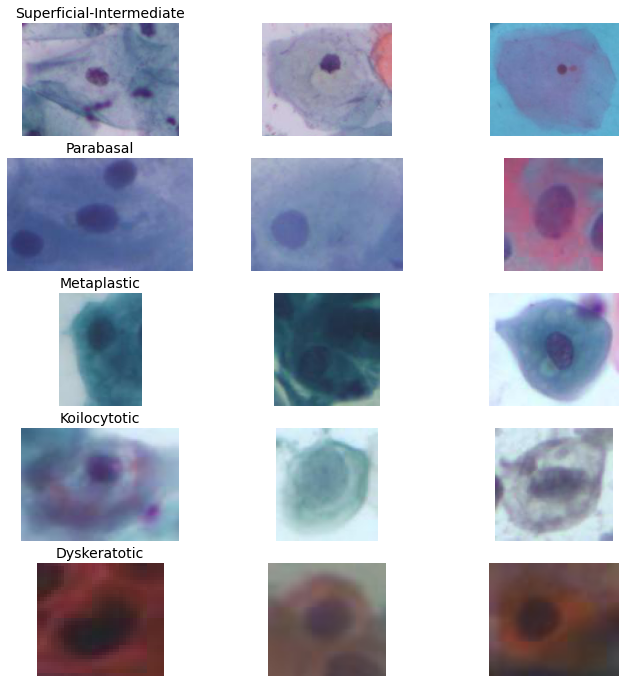

In [19]:
# Visualize some training example
### YOUR CODE

# Class names
class_names = ['Superficial-Intermediate', 'Parabasal', 'Metaplastic', 'Koilocytotic', 'Dyskeratotic']

# Define the number of images to plot for each class
num_images_per_class = 3

# Set figure size
fig, axs = plt.subplots(len(class_names), num_images_per_class, figsize=(12, 12))

# Turn off axis for all subplots
for ax in axs.flatten():
    ax.axis('off')

# Plot for each class
for i, class_name in enumerate(class_names):
    # Get the indices of images for the current class
    class_indices = [j for j, (_, label, path) in enumerate(train_dataset) if label == i]

    # Shuffle the indices
    np.random.shuffle(class_indices)

    # Plot the images
    for j in range(num_images_per_class):
        if j < len(class_indices):
            # Load the image from the path
            img = plt.imread("../data/lab-03-data/part2/" + train_dataset[class_indices[j]][2])

            # Plot the image
            axs[i, j].imshow(img)

    # Set the title of the subplot to the class name
    axs[i, 0].set_title(class_name, fontsize=14)

# Show the plot
plt.subplots_adjust(wspace=0.05, hspace=0.2)
plt.show()


### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [20]:
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
embedding_dim = train_dataset.features.shape[1]
num_classes = 5  # There are 5 classes in the dataset
model = Classifier(embedding_dim, num_classes)


The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [21]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [22]:
# Set the loss
criterion = nn.CrossEntropyLoss()

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [23]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return 100 * correct / labels.size(0)

Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [24]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    model.train()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths 
        embeddings, labels, _ = batch
        
        # Feed the embeddings to the model
        outputs = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(outputs, labels)
        
        # Reset the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        # Store the outputs, labels and loss
        full_outputs.append(outputs)
        full_labels.append(labels)
        losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [25]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in train mode
    model.eval()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        embeddings, labels, paths = batch
        
        # Feed the embeddings to the model
        outputs = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(outputs, labels)
        
        # Store the outputs, labels and loss
        full_outputs.append(outputs)
        full_labels.append(labels)
        full_paths.append(paths)
        losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
        
    # Compute the accuracy
    acc = accuracy(full_outputs, full_labels)
    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [26]:
# Main loop
epochs = 20
best_acc = 0
model_savepath = '../data'

for epoch in range(epochs):
    # Train
    train_acc, train_outputs, train_labels, train_loss = train(model, optimizer, criterion, train_loader)

    # Evaluate
    val_acc, val_outputs, val_labels, val_loss, val_paths = validate(model, criterion, val_loader)
    
    # Save the model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(model_savepath, 'best_model.pth'))
        print(f'Best model at epoch {epoch + 1} with accuracy {best_acc:.4f}')

Best model at epoch 1 with accuracy 92.9842
Best model at epoch 3 with accuracy 93.3794
Best model at epoch 4 with accuracy 93.6759
Best model at epoch 5 with accuracy 94.1700


### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [27]:
# Re-load the best model
### YOUR CODE
best_model_path = os.path.join(model_savepath, 'best_model.pth')
best_model = Classifier(embedding_dim, num_classes)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

# Evaluate
### YOUR CODE
test_acc, test_outputs, test_labels, test_loss, test_paths = validate(best_model, criterion, test_loader)
print(f'Test accuracy: {test_acc:.2f}%')


Test accuracy: 94.48%


A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

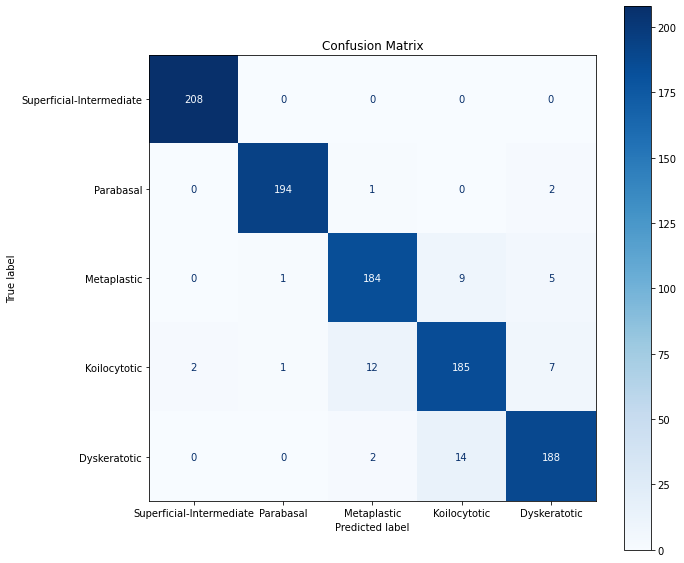

In [28]:
# Display the confusion matrix
### YOUR CODE

# Define the class labels
class_labels = ['Superficial-Intermediate', 'Parabasal', 'Metaplastic' , 'Koilocytotic', 'Dyskeratotic']

# Compute the confusion matrix
_, predicted = torch.max(test_outputs, 1)
confusion_mtx = confusion_matrix(test_labels, predicted)

# Create the ConfusionMatrixDisplay instance with the confusion matrix and class labels
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

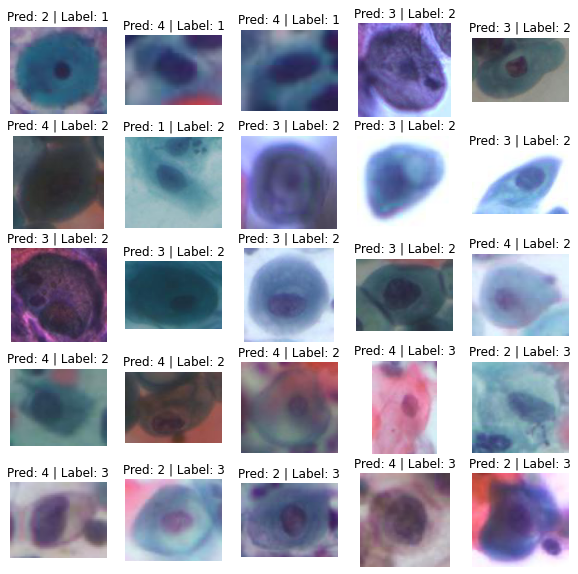

In [29]:
# Find the misclassified samples
### YOUR CODE
pred_labels = torch.argmax(test_outputs, dim=1)
misclassified_idxs = pred_labels != test_labels

# Plot the misclassified samples
### YOUR CODE
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
misclassified_samples = [Image.open("../data/lab-03-data/part2/" + test_paths[idx]) for idx in range(len(misclassified_idxs)) if misclassified_idxs[idx]]
for i, img in enumerate(misclassified_samples[:25]):
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f'Pred: {pred_labels[misclassified_idxs][i]} | Label: {test_labels[misclassified_idxs][i]}')
    axs[i//5, i%5].axis('off')